### 03_Entrenamiento_Evaluacion.ipynb:

Este notebook se dedicará al entrenamiento, la hiperparametrización, la evaluación y la interpretación de los modelos.

Preprocesamiento: Se utilizarán técnicas como One-Hot Encoding para variables categóricas y StandardScaler para las numéricas.

Modelos supervisados: Se entrenarán al menos 5 modelos, como Logistic Regression, Random Forest, Gradient Boosting, Support Vector Machine y XGBoost. Se utilizará Grid Search o Randomized Search para la hiperparametrización de al menos dos de ellos.

Evaluación: Se utilizarán métricas como Accuracy, Precision, Recall, F1-score y ROC-AUC. Se generará una matriz de confusión para cada modelo y se interpretarán los resultados. Se evaluará el impacto en el negocio, por ejemplo, analizando el costo de no identificar una disputa (falsos negativos) en comparación con el costo de investigar una queja que no se disputará (falsos positivos). Finalmente, se seleccionará el modelo final basado en un análisis conjunto de métricas y su interpretación.

**Consideraciones previas:**

El objetivo es automatizar la clasificación de "Si el cliente disputará o No" la respuesta a su reclamación por parte de la empresa, sobre un producto financiero que ésta le ofrece, mejorando así la eficiencia con la que se resuelven.

Los modelos seleccionados se relacionaron con modelos de aprendizaje automático de clasificación supervisada con clasificación multiclases.

In [23]:
# Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, recall_score
from sklearn.metrics import classification_report, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
import pickle
import joblib

# Ignoramos los warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Paths
path_data = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/data/"
path_img = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/img/"
path_models = "C:/Users/aisat/Desktop/DSPT25_RA/3-DSPT2025-ML/Proy_Final_ML_RA/3.models/"

In [3]:
df_processed = pd.read_csv(path_data + 'df_processed.csv', sep=',', encoding='utf-8')
del df_processed["Unnamed: 0"]
df_processed.head()

,Complaint ID,ZIP_NN,Day received,Response time,Product_num,State_num,Timely_response_bin,Company_response_num,Consumer_disputed_num,Issue_num,Company_num
0,1177839,85015,1,0,3,7,1,2,0,1,1940
1,1177844,15501,1,0,9,44,1,1,1,4,112
2,1177846,10552,1,0,3,40,1,2,0,4,1525
3,1177928,72633,1,0,6,5,1,1,0,3,133
4,1177930,94107,1,0,2,8,1,1,1,4,1430


In [4]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28156 entries, 0 to 28155
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Complaint ID           28156 non-null  int64
 1   ZIP_NN                 28156 non-null  int64
 2   Day received           28156 non-null  int64
 3   Response time          28156 non-null  int64
 4   Product_num            28156 non-null  int64
 5   State_num              28156 non-null  int64
 6   Timely_response_bin    28156 non-null  int64
 7   Company_response_num   28156 non-null  int64
 8   Consumer_disputed_num  28156 non-null  int64
 9   Issue_num              28156 non-null  int64
 10  Company_num            28156 non-null  int64
dtypes: int64(11)
memory usage: 2.4 MB


In [5]:
# Separar Features (X) y Target (y)
X = df_processed.drop('Consumer_disputed_num', axis=1) # Features
y = df_processed['Consumer_disputed_num']  # Target

- **Distribución de la variable Target**

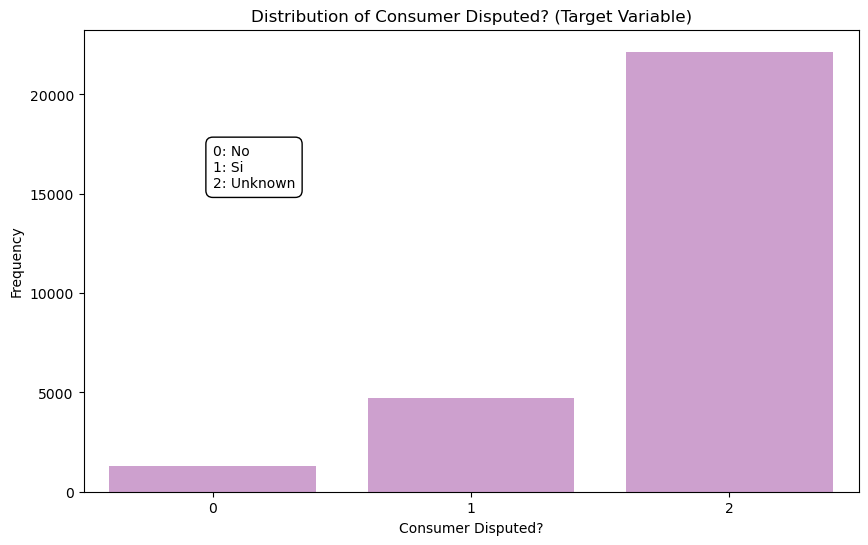

In [6]:
labels={0: 'No', 1: 'Si', 2: 'Unknown'}

plt.figure(figsize=(10, 6))
sns.barplot(x=y.value_counts().index, y=y.value_counts().values, color='#AC32AE', alpha=0.5)
plt.title("Distribution of Consumer Disputed? (Target Variable)")
plt.xlabel("Consumer Disputed?")
plt.ylabel("Frequency")
# Format the annotation text
annotation_text = "\n".join([f"{k}: {v}" for k, v in labels.items()])

# Add annotation box inside the plot (top-right corner)
plt.text(
    x=0, y= 17500,
    s=annotation_text,
    ha='left', va='top',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5')
)
plt.savefig( path_img + "Distribution_of_Target_Variable_ConsumerDisputed.tiff")

In [7]:
y.value_counts()

Consumer_disputed_num
2    22150
1     4708
0     1298
Name: count, dtype: int64

- **Features**

In [8]:
X = df_processed.drop(columns=['Consumer_disputed_num'])

- **Feature importance**

In [9]:
names = X.columns
rf = RandomForestClassifier(n_estimators = 100)
rf.fit(X, y)

scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Features'])

,Score,Features
0,0.2535,Complaint ID
1,0.1979,ZIP_NN
2,0.1357,Company_num
3,0.1335,Day received
4,0.1069,State_num
5,0.0611,Response time
6,0.0457,Product_num
7,0.0337,Company_response_num
8,0.0271,Issue_num
9,0.0049,Timely_response_bin


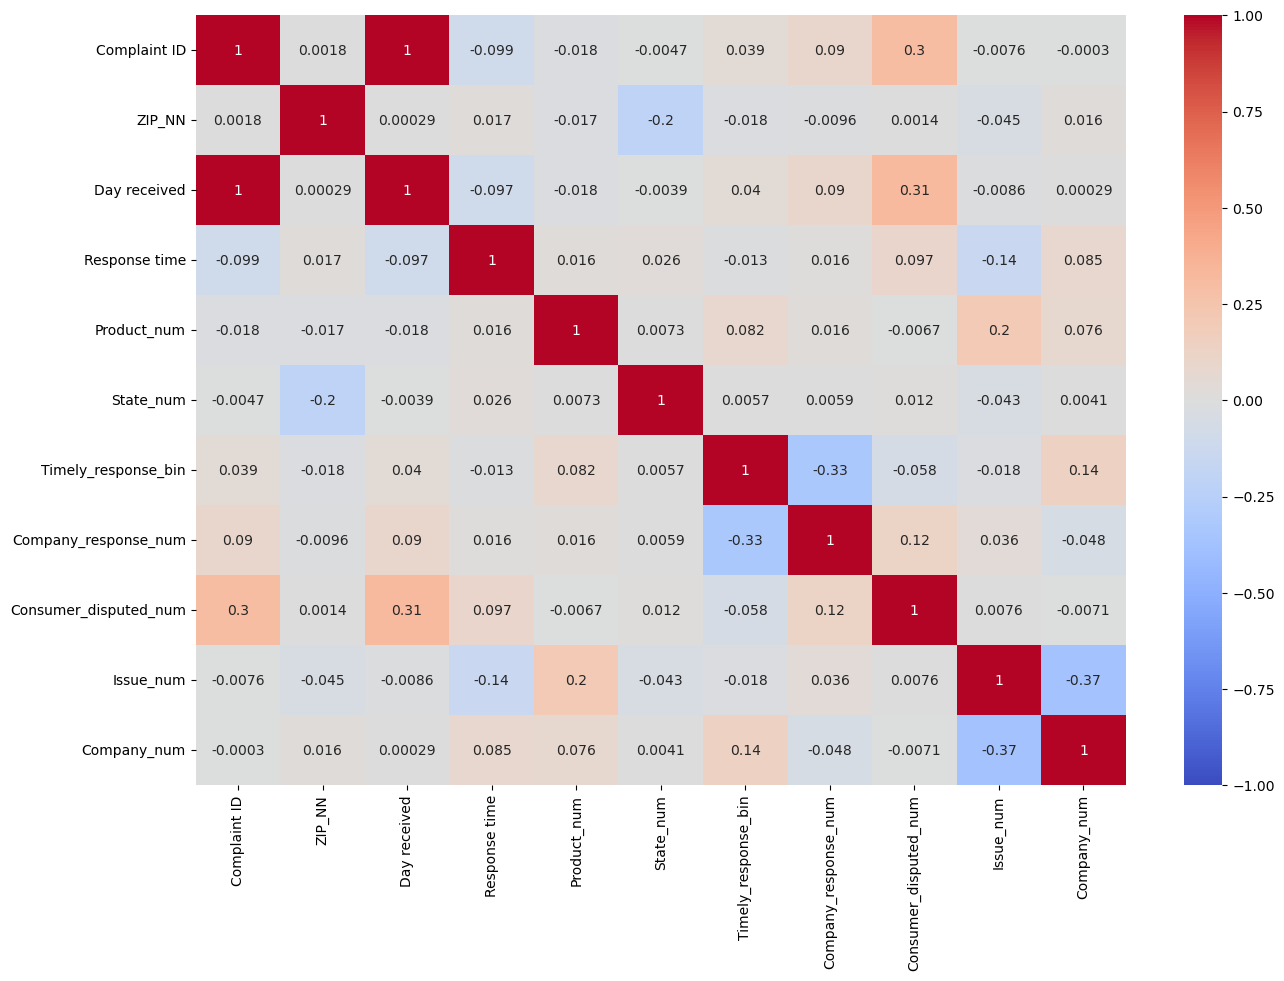

In [10]:
# Heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(df_processed.corr(), annot_kws={'fontsize': 10},vmin=-1, vmax=1, cmap ="coolwarm", annot=True);
plt.savefig(path_img + 'Heatmap Pearson.tiff')

### **Target: Consumer Disputed?**

#### **1.Preparing the data for training**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state= 42, shuffle=True)
#Stratify for mantaining the same proporcion of classes in Train and Test
print('X_train_shape: ',  X_train.shape)
print('y_train_shape: ',  y_train.shape)

print('\nX_test_shape: ',  X_test.shape)
print('y_test_shape: ',  y_test.shape)

X_train_shape:  (22524, 10)
y_train_shape:  (22524,)

X_test_shape:  (5632, 10)
y_test_shape:  (5632,)


In [12]:
over_strategy = {0: 12000, 1: 8000}  # To increase the values of the minority classes
under_strategy = {2: 4000} # To decrease the value of the majority class (2) 

In [13]:
smote = SMOTE(
    sampling_strategy=over_strategy,
    random_state=42,
    k_neighbors= 3  # 3 cluster since over_strategy variable contain 3 classes
)

X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

In [14]:
undersampler = NearMiss(sampling_strategy=under_strategy)

X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train_over, y_train_over)

In [15]:
normalizer = preprocessing.QuantileTransformer(n_quantiles=1000, output_distribution='normal', random_state=42)
X_train_normalized = normalizer.fit_transform(X_train_balanced)
X_test_normalized = normalizer.transform(X_test)

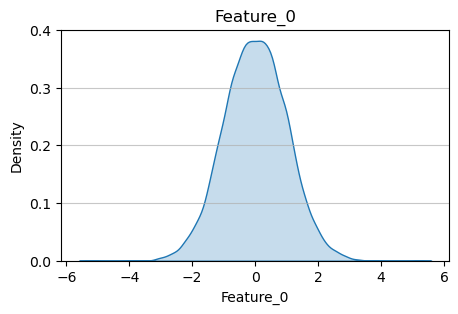

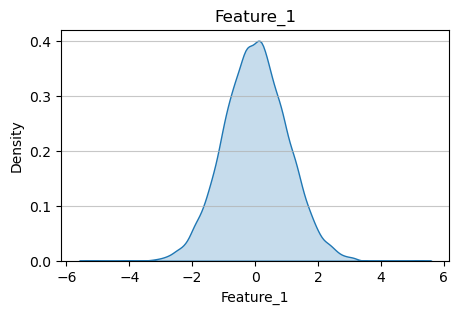

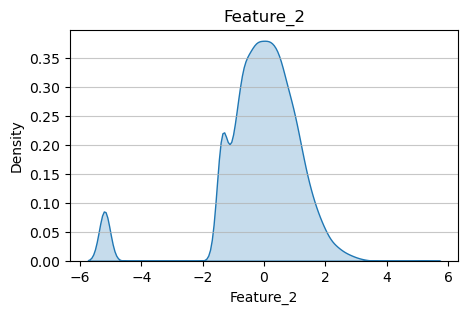

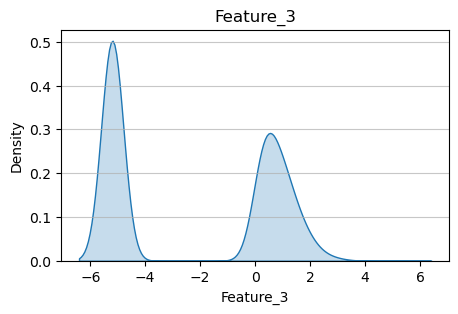

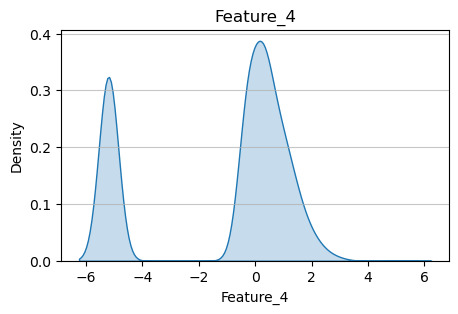

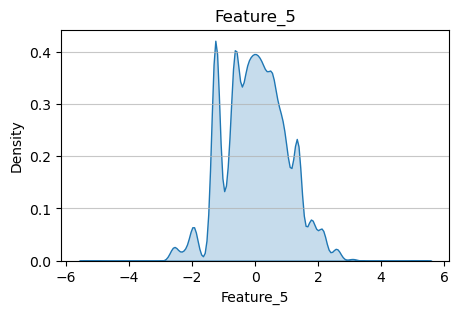

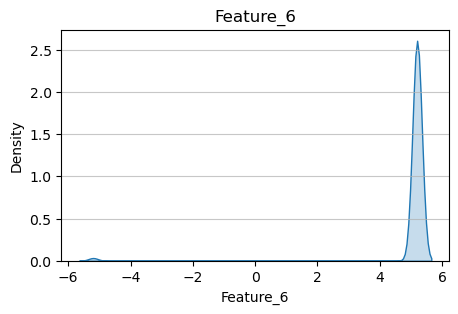

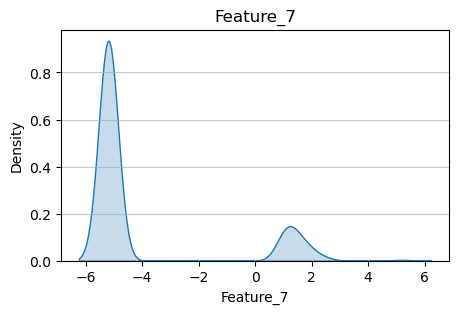

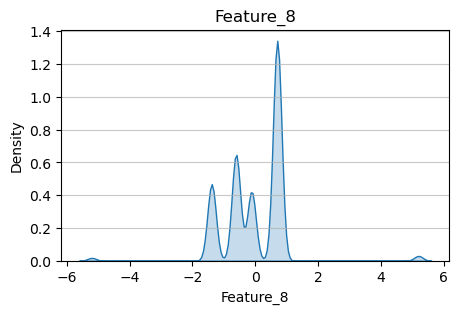

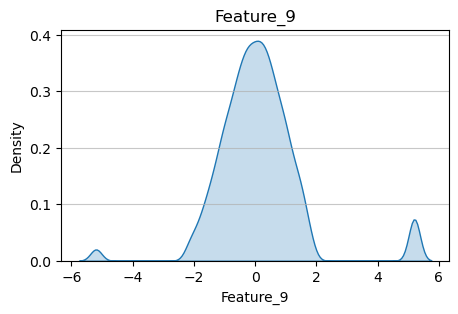

In [16]:
# Visualizing the normalized data
df_normalized = pd.DataFrame(X_train_normalized, columns=[f'Feature_{i}' for i in range(X_train_normalized.shape[1])])
for columns in df_normalized.columns: 
    plt.figure(figsize=(5,3))
    sns.kdeplot(df_normalized[columns], fill=True);
    plt.title(columns)
    plt.xlabel(columns)
    plt.ylabel('Density')
    plt.grid(axis='y', alpha=0.7)
    plt.show();

- La normalización no mejoró la distribución de los datos. Finalmente no se va ha considerar la transformación de los datos para obtener una distribución normal.

In [18]:
#Escalado de los datos sin considerar la transformación de la distribución de los datos.
scaler  = preprocessing.MinMaxScaler().fit(X_train_balanced)
X_train_scal_re = scaler.transform(X_train_balanced)

X_train_scal_re

array([[0.00864937, 0.75005037, 0.01298701, ..., 0.        , 0.4       ,
        0.01904297],
       [0.06411178, 0.36601459, 0.07792208, ..., 0.        , 0.4       ,
        0.00683594],
       [0.03111998, 0.19479813, 0.05194805, ..., 0.6       , 0.8       ,
        0.62060547],
       ...,
       [0.25037924, 0.21791643, 0.28571429, ..., 0.        , 0.8       ,
        0.19091797],
       [0.30307385, 0.17552784, 0.33766234, ..., 0.        , 0.8       ,
        0.00439453],
       [0.30194722, 0.2878153 , 0.33766234, ..., 1.        , 0.8       ,
        0.00341797]])

In [19]:
X_test_scal = scaler.transform(X_test)

### **2. Modelos**

#### **Decision Tree**

In [20]:
tree_clf = DecisionTreeClassifier(max_depth=10,random_state=42, class_weight='balanced')
tree_clf.fit(X_train_scal_re, y_train_balanced)
print("Accuracy Decision Tree:", round(tree_clf.score(X_train_scal_re, y_train_balanced), 4))

Accuracy Decision Tree: 0.812


In [21]:
predictions_tree_clf= tree_clf.predict(X_test_scal)
print("Accuracy Decision Tree in TEST data:", round(tree_clf.score(X_test_scal, y_test), 4))

Accuracy Decision Tree in TEST data: 0.5357


In [ ]:
# metric Decision Tree
print(classification_report(y_test, predictions_tree_clf))

precision_tree_clf = precision_score(y_test, predictions_tree_clf, average='macro')
recall_tree_clf = recall_score(y_test, predictions_tree_clf, average='macro')
print("Precision Decision Tree:", round(precision_tree_clf, 4))
print("Recall Decision Tree:", round(recall_tree_clf, 4))

              precision    recall  f1-score   support

           0       0.35      0.82      0.50       260
           1       0.19      0.47      0.27       942
           2       0.86      0.53      0.66      4430

    accuracy                           0.54      5632
   macro avg       0.47      0.61      0.48      5632
weighted avg       0.72      0.54      0.59      5632

Precision Decision Tree: 0.4694
Recall Decision Tree: 0.6084


In [26]:
# Save the trained model to a .pkl file
with open(path_models + 'Tree_clf_trained_model.pkl', 'wb') as file:
    pickle.dump(tree_clf, file)

#### **RandomForest**

In [ ]:
# Define weight for each classes
class_weight_op1 = {0: 1.5, 1: 1.5, 2: 0.8}
class_weight_op2 ={0: 3.0, 1: 1.0, 2: 0.8}
class_weight_op3 ={0: 4.0, 1: 1.2, 2: 0.7} 

In [ ]:
# Hiperparameters for RandomForest
param_grid = {
    'n_estimators': [200, 300, 500, 700],
    'max_depth': [10, 15, 20, 25],
    'min_samples_split': [3, 5, 10],
    'min_samples_leaf': [3, 5],
    'max_features': ['sqrt', 'log2',2],
    'class_weight': ['balanced', class_weight_op1, class_weight_op2, class_weight_op3]
}

In [29]:
recall_macro_scorer = make_scorer(recall_score, average='macro')

In [30]:
modelRF = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(estimator = modelRF,
                                    param_distributions= param_grid, scoring=recall_macro_scorer,
                                    cv=5, error_score='raise')

In [31]:
random_search.fit(X_train_scal_re, y_train_balanced)
random_search.best_params_

{'n_estimators': 700,
 'min_samples_split': 5,
 'min_samples_leaf': 3,
 'max_features': 2,
 'max_depth': 25,
 'class_weight': 'balanced'}

In [32]:
print("Accuracy Random Forest:", round(random_search.score(X_train_scal_re, y_train_balanced), 4))

Accuracy Random Forest: 0.9438


In [ ]:
# Random Forest with best parameters:
random_forest_best = RandomForestClassifier(**random_search.best_params_, random_state=42)
random_forest_best.fit(X_train_scal_re, y_train_balanced)

RandomForestClassifier(class_weight='balanced', max_depth=25, max_features=2,
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=700, random_state=42)

In [ ]:
# Predictions 
prediction_RF = random_forest_best.predict(X_test_scal)
print("Accuracy Random Forest in TEST data:", round(random_forest_best.score(X_test_scal, y_test), 4))

Accuracy Random Forest in TEST data: 0.5126


In [35]:
# metric Random Forest
print(classification_report(y_test, prediction_RF))

precision_RF = precision_score(y_test, prediction_RF, average='macro')
recall_RF = recall_score(y_test, prediction_RF, average='macro')
print("Precision Random Forest:", round(precision_RF, 4))
print("Recall Random Forest:", round(recall_RF, 4))

              precision    recall  f1-score   support

           0       0.36      0.90      0.52       260
           1       0.21      0.56      0.30       942
           2       0.88      0.48      0.62      4430

    accuracy                           0.51      5632
   macro avg       0.48      0.65      0.48      5632
weighted avg       0.74      0.51      0.56      5632

Precision Random Forest: 0.482
Recall Random Forest: 0.6455


In [36]:
# Save the trained model to a .pkl file
with open(path_models + 'RF_trained_model.pkl', 'wb') as file:
    pickle.dump(random_forest_best, file)

#### **XgBoost Model**

XgBoost documentation: https://www.geeksforgeeks.org/machine-learning/xgbclassifier/

In [39]:
# Parameters for XgBoost

param_grid_Xgb = {'booster': ['gbtree'],
                  'n_estimators' : [100,300,500],
                  'max_depth': [5, 10, 15],
                  'learning_rate': [0.01, 0.1, 0.2],
                  'subsample': [0.7,0.8,0.9],
                  'colsample_bytree': [0.7,0.8,0.9],
                  'objective': ["multi:softprob"], 
                  'gamma': [0, 0.1],
                  'reg_alpha': [0, 0.2, 1],
                  'reg_lambda': [0, 1, 2],
                  'num_class': [3],
}

In [40]:
model_xgb = xgb.XGBClassifier(random_state=42)
xgb_search = RandomizedSearchCV (estimator = model_xgb, 
                                    param_distributions= param_grid_Xgb,
                                    cv=5, error_score='raise', n_iter=30)

In [41]:
xgb_search.fit(X_train_scal_re, y_train_balanced)
xgb_search.best_estimator_

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=3, ...)

In [42]:
print("Accuracy XGBoost:", round(xgb_search.score(X_train_scal_re, y_train_balanced), 4))

Accuracy XGBoost: 0.9993


In [43]:
# XGBOOST with best parameters:
xgb_best = xgb.XGBClassifier(**xgb_search.best_params_, random_state=42)
xgb_best.fit(X_train_scal_re, y_train_balanced)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=15,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_class=3, ...)


**En un entorno Jupyter, vuelva a ejecutar esta celda para mostrar la representación HTML o confíe en el notebook.
En GitHub, no se puede renderizar la representación HTML. Intente cargar esta página con nbviewer.org.**

In [44]:
# Predictions 
prediction_XGB = xgb_best.predict(X_test_scal)
print("Accuracy XGBoost in TEST data:", round(xgb_best.score(X_test_scal, y_test), 4))

Accuracy XGBoost in TEST data: 0.4865


In [45]:
# metric XGBoost
print(classification_report(y_test, prediction_XGB))

precision_xgb = precision_score(y_test, prediction_XGB, average='macro')
recall_xgb = recall_score(y_test, prediction_XGB, average='macro')
print("Precision XGBoost:", round(precision_xgb, 4))
print("Recall XGBoost:", round(recall_xgb, 4))

              precision    recall  f1-score   support

           0       0.39      0.78      0.53       260
           1       0.20      0.63      0.31       942
           2       0.88      0.44      0.59      4430

    accuracy                           0.49      5632
   macro avg       0.49      0.62      0.47      5632
weighted avg       0.75      0.49      0.54      5632

Precision XGBoost: 0.4932
Recall XGBoost: 0.6165


In [46]:
# Save the trained model to a .pkl file
with open(path_models + 'xgb_trained_model.pkl', 'wb') as file:
    pickle.dump(xgb_best, file)

### **VotingClassifier**

In [47]:
estimators = [('RF', random_forest_best), ('Xgb', xgb_best)]
voting_clf = VotingClassifier(estimators=estimators, voting='soft')

In [48]:
# Train the model
voting_clf.fit(X_train_scal_re, y_train_balanced)
print("Accuracy Voting Classifier:", round(voting_clf.score(X_train_scal_re, y_train_balanced), 4))

Accuracy Voting Classifier: 0.9995


In [49]:
# Predictions 
prediction_Voting = voting_clf.predict(X_test_scal)

In [50]:
# metrics Voting Classifier
print(classification_report(y_test, prediction_Voting))

precision_voting = precision_score(y_test, prediction_Voting, average='macro')
recall_voting = recall_score(y_test, prediction_Voting, average='macro')
print("Precision Voting Classifier:", round(precision_voting, 4))
print("Recall Voting Classifier:", round(recall_voting, 4))

              precision    recall  f1-score   support

           0       0.38      0.79      0.51       260
           1       0.20      0.61      0.30       942
           2       0.88      0.44      0.59      4430

    accuracy                           0.49      5632
   macro avg       0.49      0.62      0.47      5632
weighted avg       0.74      0.49      0.54      5632

Precision Voting Classifier: 0.4877
Recall Voting Classifier: 0.6159


In [51]:
# Save the trained model to a .pkl file
with open(path_models + 'voting_trained_model.pkl', 'wb') as file:
    pickle.dump(voting_clf, file)

**Final model: XgBoost**
- The recalls obtained for classes 4 and 5 was the highest in comparison to DecisionTree and RandomForest.
- Aproximately, the recalls for the classes 0 to 2 were similar

In [52]:
# Save the trained model to a .pkl file
with open(path_models + 'xgb_final_model.pkl', 'wb') as file:
    pickle.dump(xgb_best, file)